<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/mlops/pistachio-dataset/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
%%writefile train_random_forest.py

import argparse
import wandb
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier # Changed classifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import os
from sklearn.decomposition import PCA
from types import SimpleNamespace
import pickle
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Defaults for sweep overrides or direct usage
default_config = SimpleNamespace(
    n_estimators=100, # Add hyperparameter for RandomForest
    max_depth=None, # Add hyperparameter for RandomForest
    loss_function="log_loss", # Placeholder, not used for RandomForest
    learning_rate="optimal", # Placeholder, not used for RandomForest
    num_iterations=1000, # Placeholder, not used for RandomForest
    log_interval=100,
    wandb_project="pistachio-classification",
    wandb_run_name="data-partioning-model-eval",
    use_wandb=True
)

def parse_args():
    """Override default arguments"""
    parser = argparse.ArgumentParser(description="RandomForest classifier training script")
    parser.add_argument("--n_estimators", type=int, default=default_config.n_estimators)
    parser.add_argument("--max_depth", type=int, default=default_config.max_depth)
    parser.add_argument("--loss_function", type=str, default=default_config.loss_function)
    parser.add_argument("--learning_rate", type=str, default=default_config.learning_rate)
    parser.add_argument("--num_iterations", type=int, default=default_config.num_iterations)
    parser.add_argument("--log_interval", type=int, default=default_config.log_interval)
    parser.add_argument("--wandb_project", type=str, default=default_config.wandb_project)
    parser.add_argument("--wandb_run_name", type=str, default=default_config.wandb_run_name)
    parser.add_argument("--use_wandb", type=bool, default=default_config.use_wandb)
    args = parser.parse_args()
    vars(default_config).update(vars(args))
    return

def load_data(n_splits=2):
# Check if the directory exists and download the processed dataset if not
    import os
    if not os.path.exists('./artifacts/pistachio-image-classification-data-split:v0/data_split.csv'):
        processed_data_at = wandb.use_artifact('pistachio-image-classification-data-split:latest')
        processed_dataset_dir = Path(processed_data_at.download())

    # Load the CSV with the data
    data_path = './artifacts/pistachio-image-classification-data-split:v0/data_split.csv'
    df = pd.read_csv(data_path)

    # Separate features and target variable
    X = df.drop(['Class', 'Stage'], axis=1)
    y = df['Class']

    # Initialize Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Create lists to store each fold's splits
    X_train_list = []
    y_train_list = []
    X_val_list = []
    y_val_list = []
    X_test_list = []
    y_test_list = []

    # Loop through each fold and store the splits
    for train_idx, val_idx in skf.split(X, y):
        # Get the train and validation splits for this fold
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Convert y_train, y_val to NumPy arrays (flatten them if needed)
        y_train_flat = y_train.to_numpy()  # Ensure it's a 1D array
        y_val_flat = y_val.to_numpy()      # Ensure it's a 1D array

        # Test data remains constant, separate from the training/validation data
        X_test = X[df['Stage'] == 'test']
        y_test = y[df['Stage'] == 'test']
        y_test_flat = y_test.to_numpy()    # Ensure it's a 1D array

        # Append the current fold's splits to the corresponding lists as 1D arrays
        X_train_list.extend(X_train.to_numpy())  # Add each fold's X_train directly
        y_train_list.extend(y_train_flat)       # Add each fold's y_train directly
        X_val_list.extend(X_val.to_numpy())      # Add each fold's X_val directly
        y_val_list.extend(y_val_flat)           # Add each fold's y_val directly
        X_test_list.extend(X_test.to_numpy())    # Add each fold's X_test directly
        y_test_list.extend(y_test_flat)         # Add each fold's y_test directly

    # Return flattened lists (1D arrays) for all splits
    return X_train_list, y_train_list, X_val_list, y_val_list, X_test_list, y_test_list

def run_experiment(config):
    run = None
    if config.use_wandb:
        run = wandb.init(project=config.wandb_project, name=f"random-frst-{config.n_estimators}-{config.max_depth}", config=config)

    X_train, y_train, X_val, y_val, X_test, y_test = load_data()

    # add pca
    pca = PCA(n_components=16)
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test) # Apply PCA to X_test

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)
    y_test_enc = le.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    classes = np.unique(y_train_enc)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)
    class_weight_dict = dict(zip(classes, class_weights))

    # Initialize RandomForestClassifier with hyperparameters
    model = RandomForestClassifier(n_estimators=config.n_estimators, max_depth=config.max_depth, random_state=42, class_weight=class_weight_dict)
    model.fit(X_train_scaled, y_train_enc)

    train_acc = accuracy_score(y_train_enc, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test_enc, model.predict(X_test_scaled))
    val_acc = accuracy_score(y_val_enc, model.predict(X_val_scaled))

    print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, val Acc: {val_acc:.4f}")

    if config.use_wandb:
        wandb.log({"train_accuracy": train_acc, "test_accuracy": test_acc, "final_val_accuracy": val_acc})

    # save the model
    model_path = os.path.join('artifacts', f'random_forest-{config.n_estimators}-{config.max_depth}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

    y_pred = model.predict(X_val_scaled)
    class_report = classification_report(y_val_enc, y_pred)

    # Calculate additional metrics
    precision = precision_score(y_val_enc, y_pred, average='weighted')
    recall = recall_score(y_val_enc, y_pred, average='weighted')
    f1 = f1_score(y_val_enc, y_pred, average='weighted')

    # Log additional metrics to wandb
    if config.use_wandb:
        wandb.log({"classification_report": wandb.Html(class_report),
                   "precision": precision,
                   "recall": recall,
                   "f1_score": f1})

        # Log ROC AUC score (binary classification)
        if len(np.unique(y_val_enc)) == 2:
          try:
            y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]  # Probability for the positive class
            roc_auc = roc_auc_score(y_val_enc, y_pred_proba)
            wandb.log({"roc_auc": roc_auc})
          except AttributeError:
            print("ROC AUC score not available for this model. Only available for models that output probabilities")
        else:
            print("ROC AUC is only for binary classification")

    return {
        "model": model,
        "scaler": scaler,
        "label_encoder": le,
        "val_accuracy": val_acc
    }

if __name__ == '__main__':
    parse_args()
    run_experiment(default_config)


Overwriting train_random_forest.py


In [35]:
!python train_random_forest.py --learning_rate=optimal --loss_function=lbfgs --num_iterations=1000 --wandb_project "pistachio-classification" --wandb_run_name "logistic_regression_run"


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vadhri-venkat to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /content/wandb/run-20250414_022311-j19q57de
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run random-frst-100-None
wandb: ⭐️ View project at https://wandb.ai/vadhri-venkat/pistachio-classification
wandb: 🚀 View run at https://wandb.ai/vadhri-venkat/pistachio-classification/runs/j19q57de
Train Acc: 1.0000, Test Acc: 1.0000, val Acc: 1.0000
wandb: 
wandb: 🚀 View run random-frst-100-None at: https://wandb.ai/vadhri-venkat/pistachio-classification/runs/j19q57de
wandb: Find logs at: wandb/run-20250414_022311-j19q57de/logs


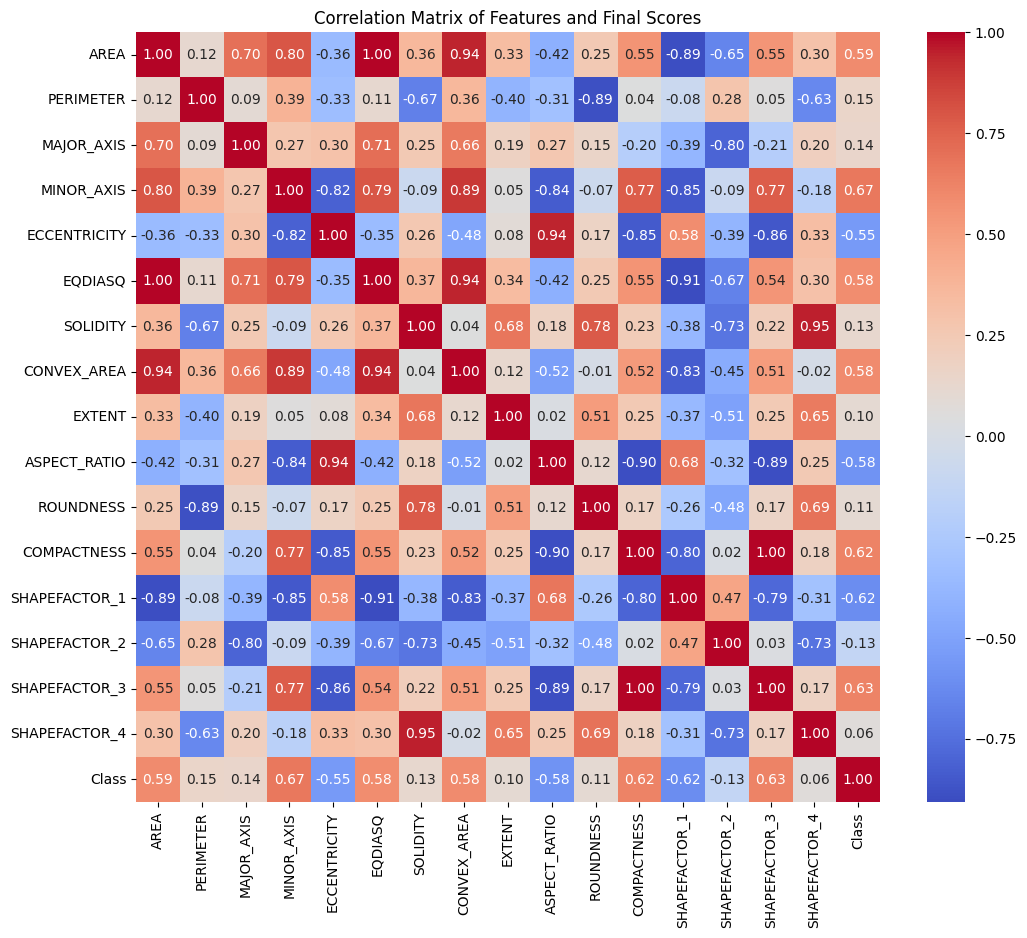

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./artifacts/pistachio-image-classification-data-split:v0/data_split.csv')

# Convert 'Class' column to numerical using Label Encoding if it's not already numerical
if df['Class'].dtype == object:  # Check if 'Class' column is of object (string) type
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['Class'] = le.fit_transform(df['Class'])

# Select only numerical features for correlation analysis
numerical_features = df.select_dtypes(include=np.number)  # Select numerical columns

# Calculate the correlation matrix for numerical features
correlation_matrix = numerical_features.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Final Scores')
plt.show()

In [37]:
!python train_random_forest.py --n_estimators=100 --max_depth=10 --num_iterations=1000 --wandb_project "pistachio-classification" --wandb_run_name "logistic_regression_run"


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vadhri-venkat to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /content/wandb/run-20250414_022323-rcbc7m59
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run random-frst-100-10
wandb: ⭐️ View project at https://wandb.ai/vadhri-venkat/pistachio-classification
wandb: 🚀 View run at https://wandb.ai/vadhri-venkat/pistachio-classification/runs/rcbc7m59
Train Acc: 0.9856, Test Acc: 0.9860, val Acc: 0.9856
wandb: 
wandb: 🚀 View run random-frst-100-10 at: https://wandb.ai/vadhri-venkat/pistachio-classification/runs/rcbc7m59
wandb: Find logs at: wandb/run-20250414_022323-rcbc7m59/logs


In [38]:
%%writefile sweep_random_forest.yaml

program: train_random_forest.py
project: pistachio-classification

method: random
metric:
  name: final_val_accuracy
  goal: maximize
parameters:
  n_estimators:
    values: [50, 100, 200]
  max_depth:
    values: [10, 20, 2]

Overwriting sweep_random_forest.yaml


In [39]:
!wandb sweep ./sweep_random_forest.yaml

wandb: Creating sweep from: ./sweep_random_forest.yaml
wandb: Creating sweep with ID: szjin2fv
wandb: View sweep at: https://wandb.ai/vadhri-venkat/pistachio-classification/sweeps/szjin2fv
wandb: Run sweep agent with: wandb agent vadhri-venkat/pistachio-classification/szjin2fv


In [43]:
!wandb agent vadhri-venkat/pistachio-classification/szjin2fv --count=100

wandb: Starting wandb agent 🕵️
2025-04-14 02:24:16,559 - wandb.wandb_agent - INFO - Running runs: []
2025-04-14 02:24:16,773 - wandb.wandb_agent - INFO - Agent received command: run
2025-04-14 02:24:16,773 - wandb.wandb_agent - INFO - Agent starting run with config:
	max_depth: 10
	n_estimators: 200
2025-04-14 02:24:16,775 - wandb.wandb_agent - INFO - About to run command: /usr/bin/env python train_random_forest.py --max_depth=10 --n_estimators=200
wandb: Currently logged in as: vadhri-venkat to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignoring project 'pistachio-classification' when running a sweep.
2025-04-14 02:24:21,790 - wandb.wandb_agent - INFO - Running runs: ['tw8agyuz']
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /content/wandb/run-20250414_022421-tw8agyuz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run random-frst-200-10
wandb: ⭐️ View project at https://wandb.ai/vadhri-venkat/pi

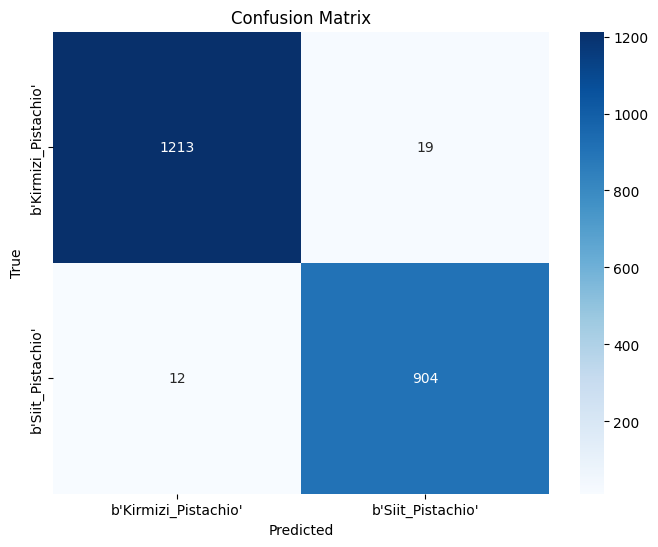

In [54]:
import pickle
import pandas as pd
import numpy as np
import wandb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Initialize Weights and Biases
wandb.init(project="pistachio-classification", name="ValPred")

# Load the latest model
model_path = "/content/artifacts/random_forest-100-10.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)

# Load your data (replace with your data loading code)
data_path = './artifacts/pistachio-image-classification-data-split:v0/data_split.csv'
df = pd.read_csv(data_path)
X = df.drop(['Class', 'Stage'], axis=1)
y = df['Class']

# Preprocess data
pca = PCA(n_components=16)
X = pca.fit_transform(X)

le = LabelEncoder()
y_enc = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Make predictions
val_predictions = model.predict(X_scaled)
ground_truth_class_ids = y_enc

# Get class names
class_names = [str(i) for i in le.classes_]

# Compute confusion matrix
cm = confusion_matrix(ground_truth_class_ids, val_predictions)

wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        preds=val_predictions, y_true=ground_truth_class_ids,
                        class_names=class_names)})

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Log the plot to wandb
wandb.log({"conf_mat": wandb.Image(plt)})

# Finish the wandb run
wandb.finish()


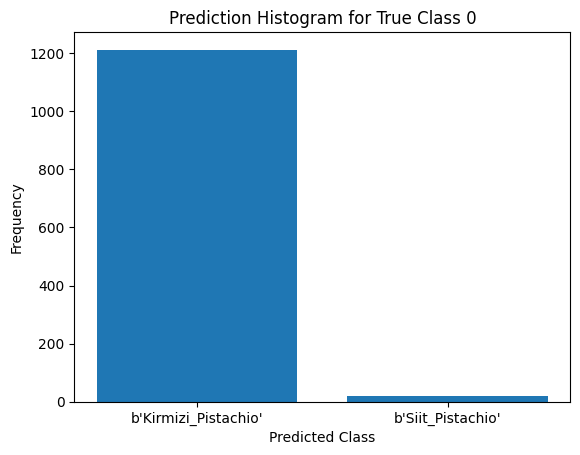

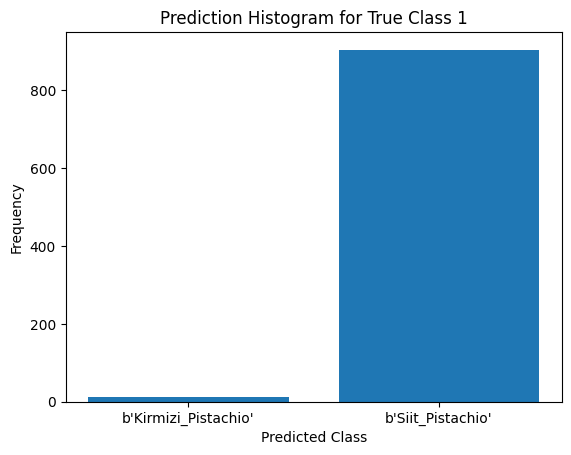

In [55]:
import wandb
import matplotlib.pyplot as plts
import numpy as np

# Initialize Weights and Biases
wandb.init(project="pistachio-classification", name="ValPredHist")

# Load the latest model (replace with your actual model loading)
model_path = "/content/artifacts/random_forest-100-10.pkl"  # Example path
with open(model_path, "rb") as f:
    model = pickle.load(f)

# Load your data and preprocess (replace with your actual data loading and preprocessing)
data_path = './artifacts/pistachio-image-classification-data-split:v0/data_split.csv'
df = pd.read_csv(data_path)
X = df.drop(['Class', 'Stage'], axis=1)
y = df['Class']

pca = PCA(n_components=16)
X = pca.fit_transform(X)

le = LabelEncoder()
y_enc = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Make predictions on the validation set (or any desired set)
val_predictions = model.predict(X_scaled)

# Assuming your classes are 0 and 1 (adjust as needed)
class_names = le.classes_

# Create prediction histograms for each class
for class_id in np.unique(y_enc):
    class_predictions = val_predictions[y_enc == class_id]
    plt.figure()  # Create a new figure for each class
    plt.hist(class_predictions, bins=np.arange(len(class_names) + 1) - 0.5, rwidth=0.8) # Adjust bins for class names
    plt.xticks(np.arange(len(class_names)), class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("Frequency")
    plt.title(f"Prediction Histogram for True Class {class_id}")
    wandb.log({f"Prediction Histogram for Class {class_id}": wandb.Image(plt)})

wandb.finish()
